In [60]:
import sys
sys.path.append("/sdf/home/a/aditi/notebooks/DMQIS/HVeV")
import glob
from matplotlib.colors import LogNorm

from arqpy import *

In [2]:
datadir = '/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/'
fns = sorted(glob.glob(datadir+'RUN08424_DUMP000*.mid.gz'))
psd_fns = sorted(glob.glob(datadir+'RUN08410_DUMP000*.mid.gz'))
chs = ['PBS2','PFS2'] # channels to use (which also serve as dictionary keys)
names = ['NFC2 A','NFC2 B']

# general
fsamp = 625000 # Hz
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4
det   = 1 # MIDAS Det01

# trigger options
trigger_mode = 3 # 0 - threshold, 1 - filter+threshold, 2 - random, 3 - external/LEMO
randomrate = 0 # random triggers to add per trace
offset = -0.00602 # fixed offset s.t. pulse = LEMO trigger - offset, sec
trigger_offsets = {} # number of bins to subtract from each trigger
for ch in chs:
    trigger_offsets[ch] = offset*fsamp

# other options
maxchi2freq = 1e4 # Hz
pretrig     = 1000 # bins
posttrig    = 4000 # bins

tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409181855
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409181855
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDat

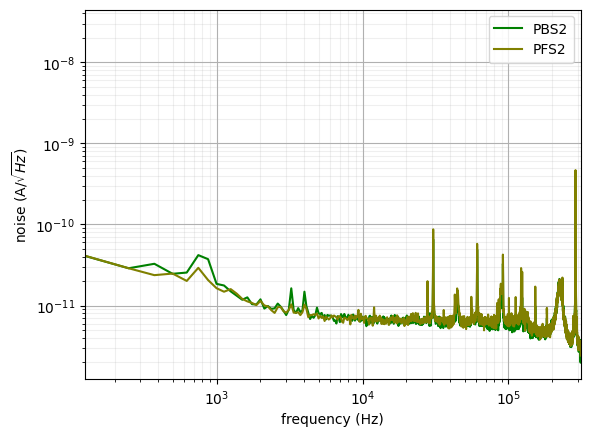

In [3]:
# make PSDs
# load traces - may take a while
noise_traces = loadEvents(files=psd_fns[:1],detectors=[det],chs=chs,ADC2A=ADC2A)
# compute PSDs, then plot
psds = makePSDs(noise_traces[det],chs=chs,nbins=tracelen,ntraces=100,fsamp=fsamp)
plotPSDs(psds,fsamp=fsamp,tracelen=tracelen)

In [4]:
noise_matrix=[]
ntraces = len(noise_traces[det]['PBS2'])
for i in range(ntraces):
    temp = []
    for c in chs:
        temp.append(noise_traces[det][c][i][:tracelen])
    noise_matrix.append(temp)

print(np.shape(noise_matrix))

(674, 2, 5000)


In [5]:
# instantiate Reduced Quantity object, without templates
rq = RQ(data=fns, chs=chs, ch_names=names, detector=det,
        fsamp=fsamp, ADC2A=ADC2A,
        pretrig=pretrig, posttrig=posttrig, 
        PSDs=psds, pulse_templates=None, # !
        maxchi2freq=maxchi2freq)

Using maxchi2freq for lpfs, also


The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDat

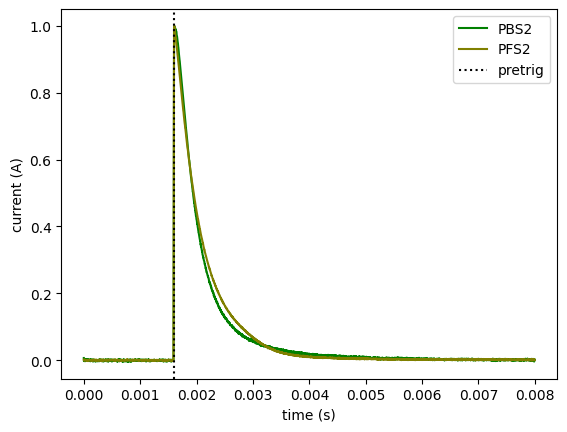

In [6]:
# use triggers to average a bunch of pulses together + use as templates
templates_dict = {}
for ch in chs:
    template = rq.averageTrigPulse(fns[:1],ch,100,offset)
    template -= np.mean(template[:100]) # "pedestal" subtraction
    template = lpf(template,2e5,10) # not actually necessary
    template /= np.max(template)
    templates_dict[ch] = template
    
    t = np.arange(len(template))/fsamp
    plt.plot(t,template,color=MIDAScolors[MIDASchs.index(ch)],label=ch)
plt.axvline(pretrig/fsamp,color='k',ls=':',label='pretrig')
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.legend()

In [7]:
# make OF (for RQs AND triggering)
rq.setTemplates(templates_dict,ch)
rq.makeOF()

In [8]:
# run trigger
rq.runTrigger(mode=trigger_mode, chs=chs, randomrate=randomrate, trigger_offsets=trigger_offsets)

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDat

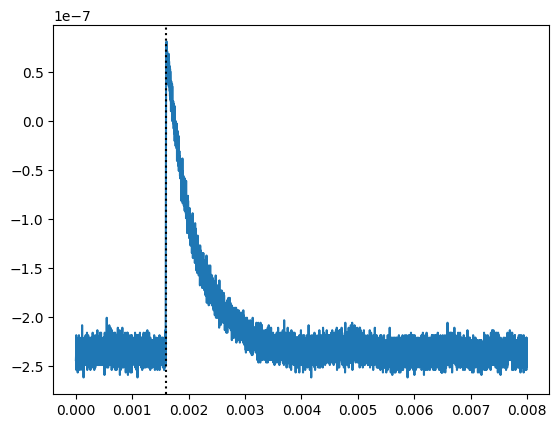

In [9]:
# did the trigger work? pulse should line up 
trace = rq.traces['PFS2'][1000]
t = np.arange(len(trace))/fsamp
plt.plot(t,trace)

plt.axvline(pretrig/fsamp,color='k',ls=':')

In [74]:
np.shape(np.array(rq.traces[ch])[:,:200])

(15922, 200)

In [10]:
pulses = []
templates = []
for c in chs:
    templates.append(templates_dict[c])
    baseline = np.mean(np.array(rq.traces[c])[:,:pretrig-200],axis=1)
    baseline_mat = []
    for bs in baseline:
        temp = list(np.ones(tracelen)*bs)
    baseline_mat.append(temp)
    baseline_mat = np.array(baseline_mat)
    pulses.append(rq.traces[c]-baseline_mat)

print(np.shape(pulses))
print(np.shape(templates))

(2, 15922, 5000)
(2, 5000)


In [22]:
# 1x1 OF
# Run optimal filter, etc. to derive RQs
rq.processTraces()

# results are stored in rq.results
RQs_1x1 = rq.results

Processing PBS2. 15922 events
Processing PFS2. 15922 events


### Correlated OF 2x2

In [11]:
#import matplotlib.pyplot as plt
import qetpy as qp
#import pytesdaq
#import numpy as np
from qetpy.core import OFnxm
from qetpy.core import OFBase

In [12]:
fs = 625e3
Noise = qp.Noise(np.array(noise_matrix), fs, chs)
Noise.calculate_csd(twosided=True) #csd is returned in A^2/Hz
csd = Noise.csd

off_diagn_terms = np.zeros_like(template)
template_matrix = np.asarray([[templates[0], off_diagn_terms],[off_diagn_terms,templates[1]]])

#this matrix is just for the 2x1 case 
# nchans = len(chs)
# nbins = len(noise_matrix[0][0])
# noise_csd = np.zeros((nchans,nbins))
# noise_csd[0,:]=noise[0] #just taking one noise trace
# noise_csd[1,:]=noise2[0]

In [13]:
ofnxm = OFnxm(channels=chs, templates=template_matrix, 
              csd=csd,sample_rate=fs, 
              pretrigger_samples=pretrig)

INFO: Adding templates with shape=(2, 2, 5000) to OF base object!
INFO: Adding noise CSD to OF base object


In [27]:
# calc
nEvents = len(pulses[0])
RQs_2x2 = {'Amps':[],'t0':[],'chi2':[]}
for eventid in range(nEvents):

    signal = np.array([pulses[0][eventid],pulses[1][eventid]])
    ofnxm.calc(signal=signal)

    # get fit result
    # a good fit will be equal to the number of dof's (nbins*nchans-ntemps)
    amp, t0, chi2 = ofnxm.get_fit_withdelay()
    RQs_2x2['Amps'].append(amp)
    RQs_2x2['t0'].append(t0)
    RQs_2x2['chi2'].append(chi2)

RQs_2x2['Amps'] = np.array(RQs_2x2['Amps'])
RQs_2x2['t0'] = np.array(RQs_2x2['t0'])
RQs_2x2['chi2'] = np.array(RQs_2x2['chi2'])
print(f"Example with Delay Fit: amp = {amp*1e6} uA, t_0 = {t0*1e6} us, chi^2 = {chi2}")

Example with Delay Fit: amp = [0.11242522 0.2931023 ] uA, t_0 = 0.0 us, chi^2 = 19739.807999789744


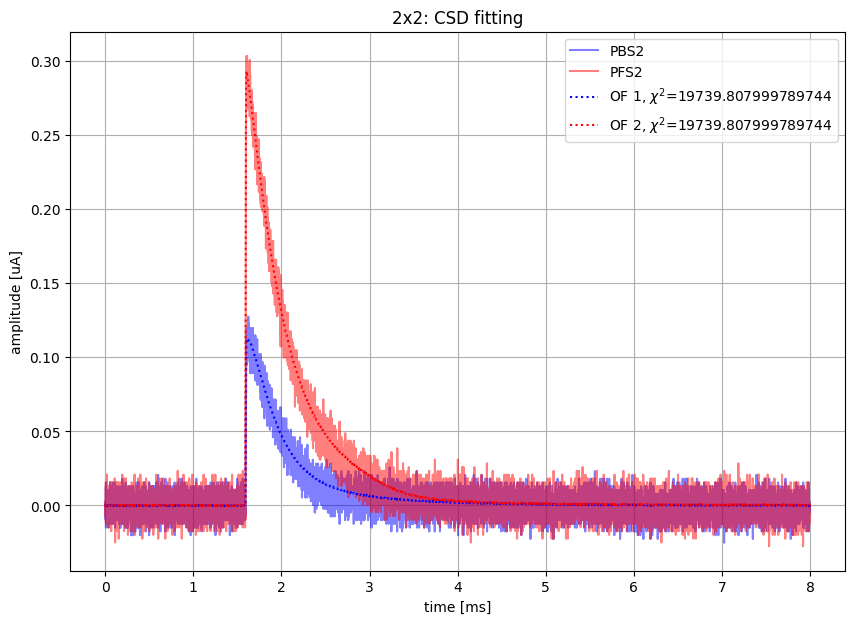

In [15]:
# time axis
xtime_ms = 1e3*np.arange(tracelen)/fs

# define figure abd plot
fig, ax = plt.subplots(figsize=(10, 7))   
ax.plot(xtime_ms, signal[0]*1e6, label=chs[0], color='blue', alpha=0.5)
ax.plot(xtime_ms, signal[1]*1e6, label=chs[1], color='red', alpha=0.5)

ax.plot(xtime_ms, amp[0]*np.roll(templates[0], int(t0*fs))*1e6, label=(r'OF 1, $\chi^2$='+f'{chi2}'), color='blue', linestyle='dotted')
ax.plot(xtime_ms, amp[1]*np.roll(templates[1], int(t0*fs))*1e6, label=(r'OF 2, $\chi^2$='+f'{chi2}'), color='red',  linestyle='dotted')
plt.grid('both')
plt.xlabel('time [ms]')
plt.ylabel('amplitude [uA]')
plt.title('2x2: CSD fitting')
plt.legend()

In [24]:
RQs_1x1.keys()

dict_keys(['OF0_A_PBS2', 'OF0_chi2_PBS2', 'OF_A_PBS2', 'OF_chi2_PBS2', 'OF_time_PBS2', 'OFL_A_PBS2', 'OFL_chi2_PBS2', 'OFL_time_PBS2', 'MF_PBS2', 'Amplitude_PBS2', 'Max_PBS2', 'MaxHead_PBS2', 'MaxTail_PBS2', 'Integral_PBS2', 'IntegralHead_PBS2', 'IntegralTail_PBS2', 'BaselineSlope_PBS2', 'Slope_PBS2', 'PlateauAmplitude_PBS2', 'RiseTime1_PBS2', 'RiseTime2_PBS2', 'RiseTime3_PBS2', 'FallTime1_PBS2', 'FallTime2_PBS2', 'FallTime3_PBS2', 'PulseWidth50_PBS2', 'PulseMaxInd_PBS2', 'MeanBase_PBS2', 'BaselineVariance_PBS2', 'TailVariance_PBS2', 'trace', 'OF0_A_PFS2', 'OF0_chi2_PFS2', 'OF_A_PFS2', 'OF_chi2_PFS2', 'OF_time_PFS2', 'OFL_A_PFS2', 'OFL_chi2_PFS2', 'OFL_time_PFS2', 'MF_PFS2', 'Amplitude_PFS2', 'Max_PFS2', 'MaxHead_PFS2', 'MaxTail_PFS2', 'Integral_PFS2', 'IntegralHead_PFS2', 'IntegralTail_PFS2', 'BaselineSlope_PFS2', 'Slope_PFS2', 'PlateauAmplitude_PFS2', 'RiseTime1_PFS2', 'RiseTime2_PFS2', 'RiseTime3_PFS2', 'FallTime1_PFS2', 'FallTime2_PFS2', 'FallTime3_PFS2', 'PulseWidth50_PFS2', 'Puls

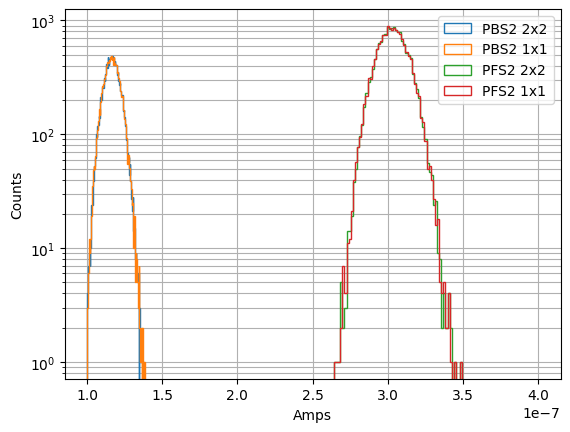

In [28]:
plt.hist(RQs_2x2['Amps'][:,0],bins=100,histtype='step',range =(1e-7,1.4e-7),label = chs[0]+' 2x2')
plt.hist(RQs_1x1['OF_A_PBS2'],bins=100,histtype='step',range =(1e-7,1.4e-7),label = chs[0]+' 1x1')
plt.hist(RQs_2x2['Amps'][:,1],bins=100,histtype='step',range =(2.6e-7,4e-7),label = chs[1]+' 2x2')
plt.hist(RQs_1x1['OF_A_PFS2'],bins=100,histtype='step',range =(2.6e-7,4e-7),label = chs[1]+' 1x1')

plt.legend()
plt.yscale('log')
plt.xlabel('Amps')
plt.ylabel('Counts')
plt.grid(which = 'both')

plt.show()

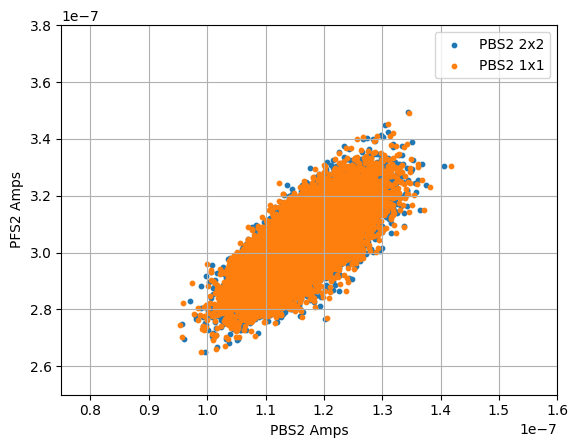

In [35]:
plt.scatter(RQs_2x2['Amps'][:,0],RQs_2x2['Amps'][:,1],s=10,label = chs[0]+' 2x2')
plt.scatter(RQs_1x1['OF_A_PBS2'],RQs_1x1['OF_A_PFS2'],s=10,label = chs[0]+' 1x1')

plt.legend()
#plt.yscale('log')
plt.xlabel('PBS2 Amps')
plt.ylabel('PFS2 Amps')
plt.grid(which = 'both')
plt.xlim(0.75e-7,1.6e-7)
plt.ylim(2.5e-7,3.8e-7)

plt.show()

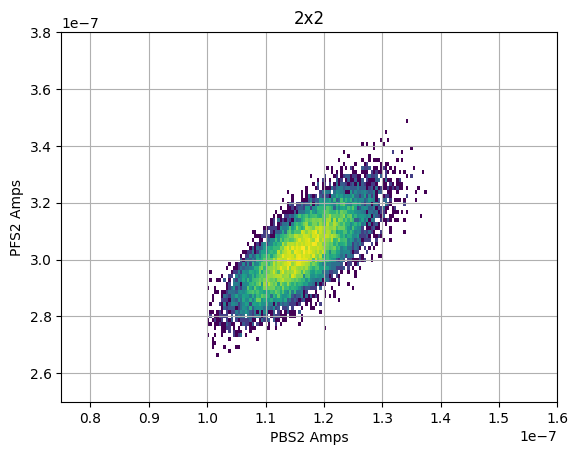

In [63]:
plt.hist2d(RQs_2x2['Amps'][:,0],RQs_2x2['Amps'][:,1],bins=100,range =((1e-7,1.4e-7),(2.6e-7,4e-7)),label = chs[0]+' 2x2',norm=LogNorm())
#plt.hist2d(RQs_1x1['OF_A_PBS2'],RQs_1x1['OF_A_PFS2'],bins=10,label = chs[0]+' 1x1')

#plt.legend()
#plt.yscale('log')
plt.xlabel('PBS2 Amps')
plt.ylabel('PFS2 Amps')
plt.grid(which = 'both')
plt.xlim(0.75e-7,1.6e-7)
plt.ylim(2.5e-7,3.8e-7)
plt.title('2x2')

plt.show()

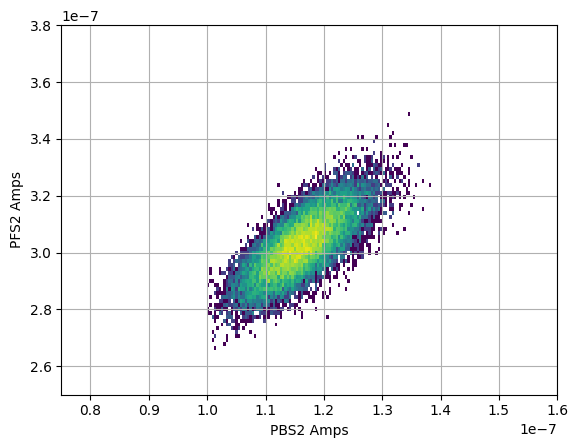

In [62]:
#plt.hist2d(RQs_2x2['Amps'][:,0],RQs_2x2['Amps'][:,1],bins=100,range =((1e-7,1.4e-7),(2.6e-7,4e-7)),label = chs[0]+' 2x2')
plt.hist2d(RQs_1x1['OF_A_PBS2'],RQs_1x1['OF_A_PFS2'],bins=100,range =((1e-7,1.4e-7),(2.6e-7,4e-7)),label = chs[0]+' 1x1',norm=LogNorm())

#plt.legend()
#plt.yscale('log')
plt.xlabel('PBS2 Amps')
plt.ylabel('PFS2 Amps')
plt.grid(which = 'both')
plt.xlim(0.75e-7,1.6e-7)
plt.ylim(2.5e-7,3.8e-7)

plt.show()

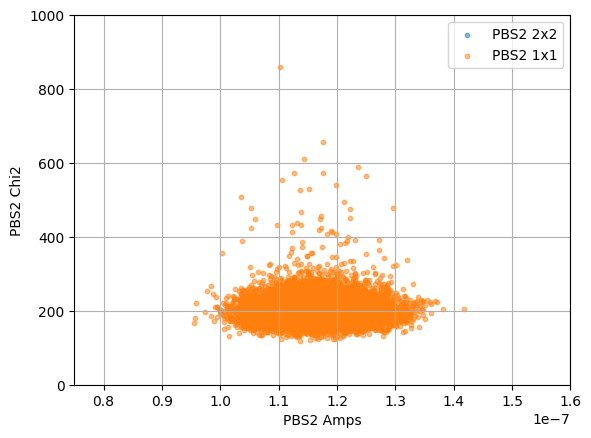

In [49]:
plt.scatter(RQs_2x2['Amps'][:,0],RQs_2x2['chi2'],s=10,label = chs[0]+' 2x2',alpha=0.5)
plt.scatter(RQs_1x1['OF_A_PBS2'],RQs_1x1['OF_chi2_PBS2'],s=10,label = chs[0]+' 1x1',alpha=0.5)

plt.legend()
#plt.yscale('log')
plt.xlabel('PBS2 Amps')
plt.ylabel('PBS2 Chi2')
plt.grid(which = 'both')
plt.xlim(0.75e-7,1.6e-7)
plt.ylim(0,1e3)

plt.show()